### Import packages

In [1]:
library(prabclus)
library(Matrix)
library(Rtsne)
library(ggplot2) 

Loading required package: MASS
Loading required package: mclust
Package 'mclust' version 5.4.3
Type 'citation("mclust")' for citing this R package in publications.


### Preprocess

`bsub < count_reads_peaks.sh`

In [2]:
path = './count_reads_peaks_output/'
files <- list.files(path,pattern = "\\.txt$")
length(files)

[1] 2034

In [ ]:
#assuming tab separated values with a header    
datalist = lapply(files, function(x)fread(paste0(path,x))$V4) 
#assuming the same header/columns for all files
datafr = do.call("cbind", datalist) 

In [4]:
dim(datafr)

[1] 237450   2034

In [5]:
df_regions = read.csv("../../input/combined.sorted.merged.bed",
                      sep = '\t',header=FALSE,stringsAsFactors=FALSE)

In [6]:
dim(df_regions)

[1] 237450      3

In [7]:
peaknames = paste(df_regions$V1,df_regions$V2,df_regions$V3,sep = "_")

In [8]:
head(peaknames)

[1] "chr1_10413_10625"   "chr1_13380_13624"   "chr1_16145_16354"  
[4] "chr1_96388_96812"   "chr1_115650_115812" "chr1_237625_237888"

In [9]:
head(sapply(strsplit(files,'\\.'),'[', 1))

[1] "BM1077-CLP-Frozen-160106-13" "BM1077-CLP-Frozen-160106-14"
[3] "BM1077-CLP-Frozen-160106-2"  "BM1077-CLP-Frozen-160106-21"
[5] "BM1077-CLP-Frozen-160106-27" "BM1077-CLP-Frozen-160106-3"

In [10]:
colnames(datafr) = sapply(strsplit(files,'\\.'),'[', 1)
rownames(datafr) = peaknames

In [11]:
head(datafr)

,BM1077-CLP-Frozen-160106-13,BM1077-CLP-Frozen-160106-14,BM1077-CLP-Frozen-160106-2,BM1077-CLP-Frozen-160106-21,BM1077-CLP-Frozen-160106-27,BM1077-CLP-Frozen-160106-3,BM1077-CLP-Frozen-160106-36,BM1077-CLP-Frozen-160106-42,BM1077-CLP-Frozen-160106-44,BM1077-CLP-Frozen-160106-50,⋯,singles-PB1022-mono-160128-81,singles-PB1022-mono-160128-82,singles-PB1022-mono-160128-83,singles-PB1022-mono-160128-84,singles-PB1022-mono-160128-85,singles-PB1022-mono-160128-86,singles-PB1022-mono-160128-89,singles-PB1022-mono-160128-90,singles-PB1022-mono-160128-95,singles-PB1022-mono-160128-96
chr1_10413_10625,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1_13380_13624,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1_16145_16354,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1_96388_96812,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,2,0,0
chr1_115650_115812,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1_237625_237888,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [12]:
dim(datafr)

[1] 237450   2034

In [13]:
# saveRDS(datafr, file = './datafr.rds')
# datafr = readRDS('./datafr.rds')

In [14]:
filter_peaks <- function (datafr,cutoff = 0.01){
    binary_mat = as.matrix((datafr > 0) + 0)
    binary_mat = Matrix(binary_mat, sparse = TRUE) 
    num_cells_ncounted = Matrix::rowSums(binary_mat)
    ncounts = binary_mat[num_cells_ncounted >= dim(binary_mat)[2]*cutoff,]
    ncounts = ncounts[rowSums(ncounts) > 0,]    
    
    options(repr.plot.width=4, repr.plot.height=4)
    hist(log10(num_cells_ncounted),main="No. of Cells Each Site is Observed In",breaks=50)
    abline(v=log10(min(num_cells_ncounted[num_cells_ncounted >= dim(binary_mat)[2]*cutoff])),lwd=2,col="indianred")
#     hist(log10(new_counts),main="Number of Sites Each Cell Uses",breaks=50)
    datafr_filtered = datafr[rownames(ncounts),]
    return(datafr_filtered)
}


getJaccardDist <- function(cdBinary){
        
    if(colnames(cdBinary[,2:3])[1] == 'start' && colnames(cdBinary[,2:3])[2] == 'end'){
        SingleCell.Binary <- cdBinary[,4:(dim(cdBinary)[2])]
    }
    else
        SingleCell.Binary <- cdBinary
    
    
    SingleCell.Binary.Jaccard <- jaccard(as.matrix(SingleCell.Binary))
    
    return(SingleCell.Binary.Jaccard)
}


plot_tSNE <- function(cdBinary, nDimToUSE, groups=NULL, cellName, perplexity_division, ret.val=FALSE , text.label=FALSE, title=""){

    if(missing(nDimToUSE)){
        stop("ERROR: Number of PCA's \"nDimToUSE\" to use is missing")
    }
    if(missing(ret.val)){
        ret.val = FALSE
    }
    
    if(text.label==TRUE & missing(cellName)){
        stop("ERROR: Please give cellName")
    }
    
    if(missing(perplexity_division)){
        stop("ERROR: Please enter the number with which you want to divide the dimension of your data for perplexity setting")
    }
        
    
    #SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    #FinalPCAData <- t(SingleCell.Binary.Jaccard)
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    fit <- cmdscale(as.dist(SingleCell.Binary.Jaccard),eig=TRUE, k=nDimToUSE)

    #pcaPRComp <- prcomp(FinalPCAData)

    
    #rtsne_pca_out <- Rtsne(as.matrix(pcaPRComp$x[,1:nPCAToUSE]), perplexity = dim(pcaPRComp$x)[1]/perplexity_division, check_duplicates = FALSE)
    rtsne_pca_out <- Rtsne(as.matrix(fit$points[,1:nDimToUSE]), perplexity = perplexity_division, 
                           check_duplicates = FALSE, pca=FALSE, theta=0.01, max_iter=3000)
    
    if(is.null(groups)){
        if(ret.val==TRUE)
            df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2], cellName=cellName)
        else
            df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2])
        p1 <- ggplot(df, aes_string(x="X",y ="Y"))
    }
    else{
        if(ret.val==TRUE)
            df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2], Cell=colnames(SingleCell.Binary.Jaccard), Batch=groups, cellName=cellName)
        else
            df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2], Cell=colnames(SingleCell.Binary.Jaccard), Batch=groups)
        p1 <- ggplot(df, aes_string(x="X",y ="Y", color="Batch"))
    }
    

    p1<-p1 + ggtitle("t-SNE plot")
    p1<-p1 + geom_point(size = 2) 
    p1<-p1 + xlab(paste("Dim-1"))
    p1<-p1 + ylab("Dim-2")+
        theme_light(base_size=24) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))
#     if(length(levels(groups)) < 12)
#         p1 <- p1 + scale_colour_brewer(palette="Set1")
    if(text.label==TRUE)
        p1<-p1 + geom_text(data=df,aes(label=cellName),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45)
    print(p1)
    return(df)
}

### Obtain Feature Matrix

In [15]:
start_time <- Sys.time()

In [16]:
metadata <- read.table('../../input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)

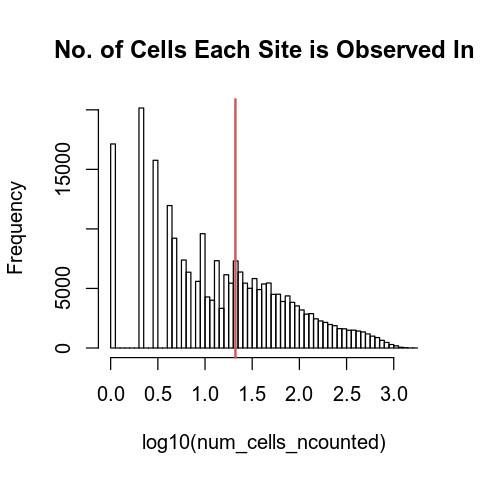

In [17]:
datafr_filtered <- filter_peaks(datafr)

In [18]:
dim(datafr_filtered)

[1] 101172   2034

In [19]:
cdBinary = as.matrix((datafr_filtered > 0) + 0)
cdBinary = Matrix(cdBinary, sparse = TRUE) 

In [20]:
## use the similar number of dimensions as shown in tutorial https://github.com/ManchesterBioinference/Scasat/blob/master/ScAsAT_functions_Buenrostro_All_Bam_Together.ipynb
k = 15
SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
fit <- cmdscale(as.dist(SingleCell.Binary.Jaccard),eig=TRUE, k=k)
fm_Scasat = t(fit$points)

In [21]:
dim(fm_Scasat)
fm_Scasat[1:5,1:5]

[1]   15 2034

BM1077-CLP-Frozen-160106-13,BM1077-CLP-Frozen-160106-14,BM1077-CLP-Frozen-160106-2,BM1077-CLP-Frozen-160106-21,BM1077-CLP-Frozen-160106-27
-0.156576408,-0.174722000,-0.174833227,-0.17792538,-0.162177358
0.010935828,-0.000800685,0.002288373,0.03212302,0.030131763
0.035164844,0.033386794,0.042648757,0.04818811,0.038136643
0.002767412,0.039683796,0.035835847,0.01590507,-0.002331473
0.026593068,0.017911028,0.025921123,0.01378666,0.025628992


In [22]:
end_time <- Sys.time()

In [23]:
end_time - start_time

Time difference of 27.51361 secs

In [24]:
rownames(fm_Scasat) = paste('Dim',1:dim(fm_Scasat)[1])
fm_Scasat[1:5,1:5]

,BM1077-CLP-Frozen-160106-13,BM1077-CLP-Frozen-160106-14,BM1077-CLP-Frozen-160106-2,BM1077-CLP-Frozen-160106-21,BM1077-CLP-Frozen-160106-27
Dim 1,-0.156576408,-0.174722000,-0.174833227,-0.17792538,-0.162177358
Dim 2,0.010935828,-0.000800685,0.002288373,0.03212302,0.030131763
Dim 3,0.035164844,0.033386794,0.042648757,0.04818811,0.038136643
Dim 4,0.002767412,0.039683796,0.035835847,0.01590507,-0.002331473
Dim 5,0.026593068,0.017911028,0.025921123,0.01378666,0.025628992


In [25]:
all(colnames(fm_Scasat) == rownames(metadata))

[1] TRUE

In [26]:
saveRDS(fm_Scasat, file = '../../output/feature_matrices/FM_Scasat_buenrostro2018.rds')

### Downstream Analysis

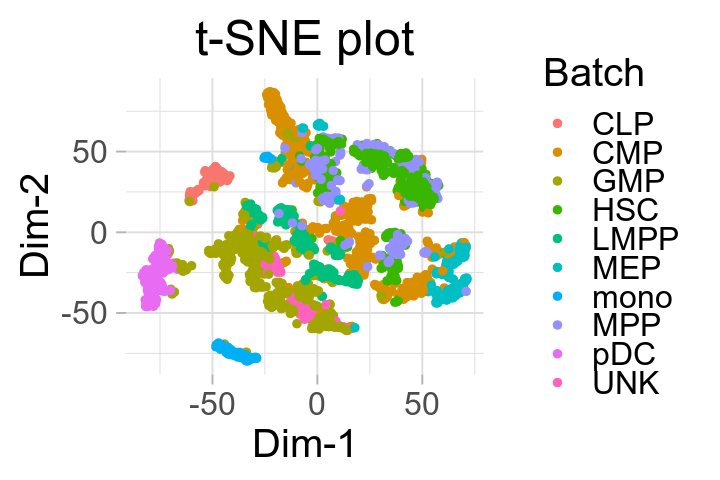

In [27]:
options(repr.plot.width=6, repr.plot.height=4)
set.seed(2019)
tsNE_out_2PCs <- plot_tSNE(cdBinary, k, groups=metadata$label, perplexity=30, 
                              cellName=rownames(metadata),ret.val=TRUE, text.label=F)

In [28]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data/pinello/SHARED_SOFTWARE/anaconda3/envs/ATACseq_scasat/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.0.0  Rtsne_0.15     Matrix_1.2-14  prabclus_2.2-7 mclust_5.4.3  
[6] MASS_7.3-50   

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.1       compiler_3.5.1   pillar_1.3.1     plyr_1.8.4      
 [5] bindr_0.1.1      base64enc_0.1-3  tools_3.5.1      digest_

In [29]:
save.image(file = 'Scasat_buenrostro2018.RData')